# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [1]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

## Leitura, normalização e visualização dos dados

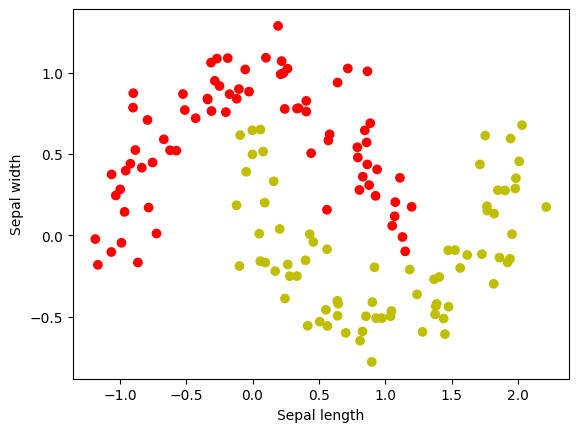

In [2]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option == 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option == 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option == 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option == 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [3]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [4]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=3, bias=True)
  )
)


## _predict_ utilizada para predição de classes e na visualização

In [5]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

## Classe para visualização dinâmica

In [6]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [7]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

Final loss: tensor(0.0052)


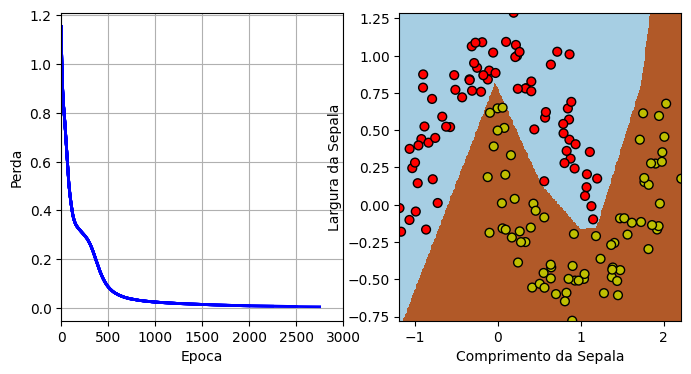

In [8]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [9]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([5, 2])
tensor([[ 0.1505, -0.8602],
        [ 0.7478, -1.3159],
        [ 1.6331, -0.2722],
        [-1.7361, -1.3187],
        [-3.1240,  0.0097]])
dense.0.bias    torch.Size([5])
tensor([ 0.8858, -0.2118, -1.6796,  1.8699, -0.1066])
dense.2.weight  torch.Size([5, 5])
tensor([[ 0.4301, -0.6269, -1.1746, -1.2036,  1.8006],
        [-0.3880, -0.2181, -0.0376, -0.4403, -0.1682],
        [-0.2882,  0.1675,  0.1775, -0.1889, -0.3671],
        [ 0.4061, -0.2971, -1.1780, -0.2454,  0.9418],
        [ 0.8209,  1.2875,  1.5897,  2.4561, -2.3724]])
dense.2.bias    torch.Size([5])
tensor([ 1.1713, -0.3461, -0.1088,  1.6642, -0.9671])
dense.4.weight  torch.Size([3, 5])
tensor([[ 2.0186,  0.0666,  0.4278,  2.0619, -2.5479],
        [-2.0171, -0.2747, -0.3166, -0.7170,  3.1944],
        [ 0.2890,  0.3190, -0.0247, -0.7266, -0.7608]])
dense.4.bias    torch.Size([3])
tensor([ 1.8653, -0.1526, -1.5610])


### Avaliação do classificador

In [10]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  1.0


### Matriz de confusão

In [11]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,75,0
1,0,75


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.
2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.
3. O que ocorre quando não se utiliza ativação não linear entre camadas?

#### 1. Quanto mais neurônios menor a perda, porém maior o custo computacional.

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
from torch.autograd import Variable
import torch.nn as nn
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Classe do Modelo
class Modelo_EX1(nn.Module):
    def __init__(self):
        super(Modelo_EX1, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 25),
            nn.ReLU(),
            nn.Linear(25, 25),
            nn.ReLU(),
            nn.Linear(25, 3),
        )

    def forward(self, x):
        x = self.dense(x)
        return x

Final loss: tensor(0.0027)
Acurácia final: 1.00


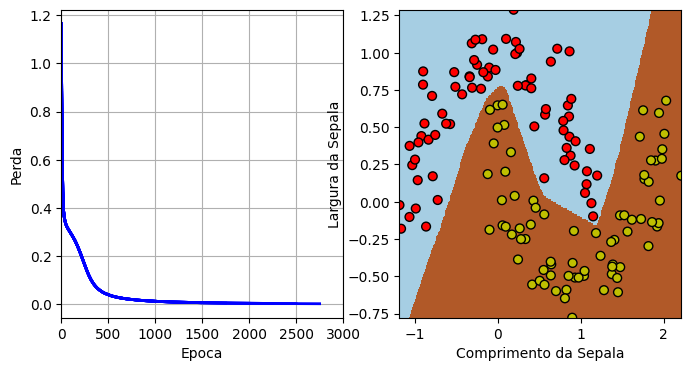

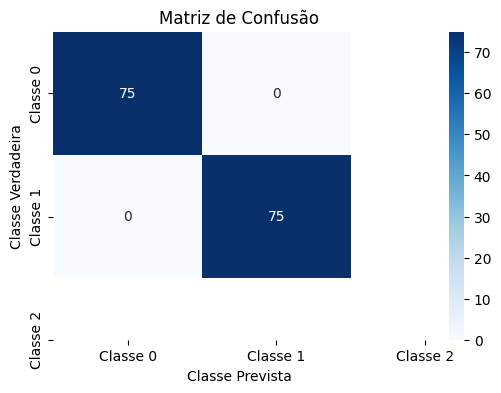

In [14]:
# Inicializando o modelo
model_ex1 = Modelo_EX1()
print(model_ex1)

# Hiperparâmetros
lr = 0.15
batch_size = 150
nb_epoch = 3000
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ex1.parameters(), lr=lr)

# Definição do plotter para visualizar fronteiras (opcional)
boundary_plot = BoundaryPlotter(model_ex1, Xc, Y, nb_epoch)

# Treinamento
boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # Previsão da rede
    output = model_ex1(Variable(X_tensor))

    # Calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Salva perdas e atualiza o plot
    losses.append(loss.data)
    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

# Avaliação
Y_hat = predict(model_ex1, X_tensor)

# Cálculo da acurácia
accuracy = accuracy_score(Y, Y_hat)
print(f"Acurácia final: {accuracy:.2f}")

# Matriz de confusão
conf_matrix = confusion_matrix(Y, Y_hat)

# Exibir matriz de confusão como gráfico
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d",
            xticklabels=['Classe 0', 'Classe 1', 'Classe 2'],
            yticklabels=['Classe 0', 'Classe 1', 'Classe 2'])
plt.xlabel("Classe Prevista")
plt.ylabel("Classe Verdadeira")
plt.title("Matriz de Confusão")
plt.show()

#### 2. Não deu pra separar muito bem os grupos pois o problema é não linear e a sigmoid é linear, então a separação fica errada.

In [15]:
# Classe do Modelo 2
class Modelo_EX2(nn.Module):
    def __init__(self):
        super(Modelo_EX2, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.Sigmoid(),
            nn.Linear(5, 5),
            nn.Sigmoid(),
            nn.Linear(5, 3),
        )

    def forward(self, x):
        x = self.dense(x)
        return x


Final loss: tensor(0.3223)
Acurácia final: 0.87


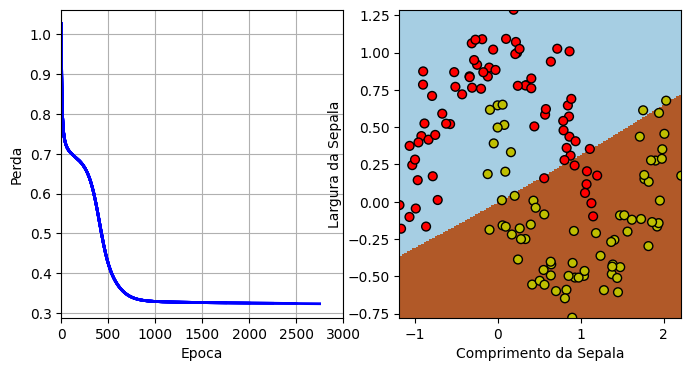

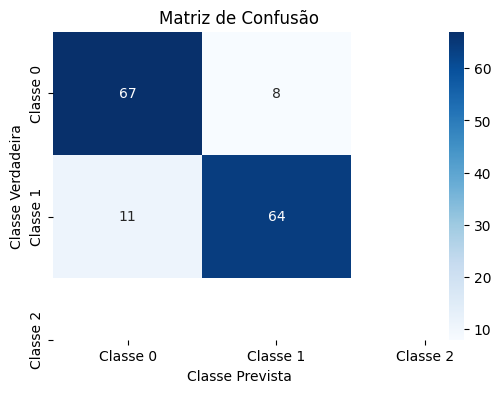

In [16]:
# Inicializando o modelo
model_ex2 = Modelo_EX2()
print(model_ex2)

# Hiperparâmetros
lr = 0.15
batch_size = 150
nb_epoch = 3000
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ex2.parameters(), lr=lr)

# Definição do plotter para visualizar fronteiras (opcional)
boundary_plot = BoundaryPlotter(model_ex2, Xc, Y, nb_epoch)

# Treinamento
boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # Previsão da rede
    output = model_ex2(Variable(X_tensor))

    # Calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Salva perdas e atualiza o plot
    losses.append(loss.data)
    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

# Avaliação
Y_hat = predict(model_ex2, X_tensor)

# Cálculo da acurácia
accuracy = accuracy_score(Y, Y_hat)
print(f"Acurácia final: {accuracy:.2f}")

# Matriz de confusão
conf_matrix = confusion_matrix(Y, Y_hat)

#Espaçamento

# Exibir matriz de confusão como gráfico
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d",
            xticklabels=['Classe 0', 'Classe 1', 'Classe 2'],
            yticklabels=['Classe 0', 'Classe 1', 'Classe 2'])
plt.xlabel("Classe Prevista")
plt.ylabel("Classe Verdadeira")
plt.title("Matriz de Confusão")
plt.show()

#### 3. Não dá pra separar as camadas, mas percebe-se uma queda acentuada da perda logo nas primeiras épocas.

In [17]:
# Classe do Modelo
class Modelo_EX3(nn.Module):
    def __init__(self):
        super(Modelo_EX3, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.Linear(5, 5),
            nn.Linear(5, 3),
        )

    def forward(self, x):
        x = self.dense(x)
        return x

Final loss: tensor(0.3221)
Acurácia final: 0.87


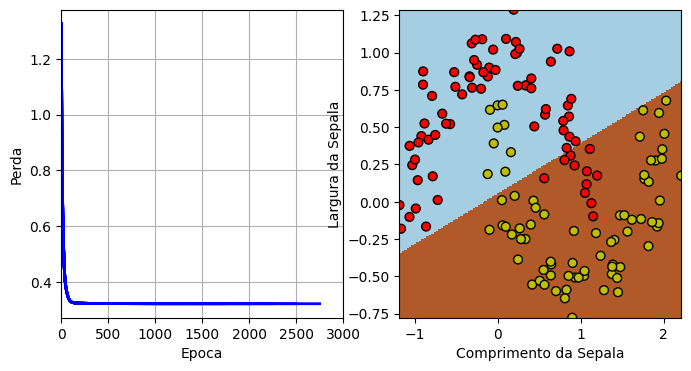

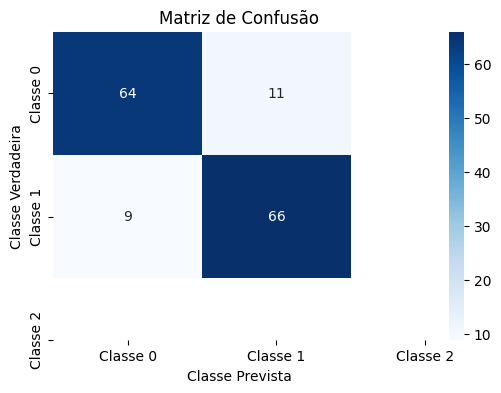

In [18]:
# Inicializa o modelo
model_ex3 = Modelo_EX3()
print(model_ex3)

# Hiperparâmetros
lr = 0.15
batch_size = 150
nb_epoch = 3000
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ex3.parameters(), lr=lr)

# Definição do plotter para visualizar fronteiras (opcional)
boundary_plot = BoundaryPlotter(model_ex3, Xc, Y, nb_epoch)

# Treinamento
boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # Previsão da rede
    output = model_ex3(Variable(X_tensor))

    # Calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Salva perdas e atualiza o plot
    losses.append(loss.data)
    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

# Avaliação
Y_hat = predict(model_ex3, X_tensor)

# Cálculo da acurácia
accuracy = accuracy_score(Y, Y_hat)
print(f"Acurácia final: {accuracy:.2f}")

# Matriz de confusão
conf_matrix = confusion_matrix(Y, Y_hat)

#Espaçamento

# Exibir matriz de confusão como gráfico
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d",
            xticklabels=['Classe 0', 'Classe 1', 'Classe 2'],
            yticklabels=['Classe 0', 'Classe 1', 'Classe 2'])
plt.xlabel("Classe Prevista")
plt.ylabel("Classe Verdadeira")
plt.title("Matriz de Confusão")
plt.show()